# Understanding Employment Trends in NYC Job Postings

```
Team 9 Members:
  Nikhil Patil
  Shimil Shijo
  Srinivasa Reddy Gurram
```

This project analyzes job market disparities in New York City using the NYC Jobs dataset. It investigates salary variations, competitive postings, residency requirements, and demographic impacts through regression, clustering, and classification techniques. The findings are visualized through dashboards to provide actionable insights into employment trends and inequalities.

## Install and Import necessary packages

In [1]:
!pip install shap

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
import seaborn.objects as so
import statsmodels.api as sm
from tabulate import tabulate
from sklearn.model_selection import train_test_split, cross_val_score,  GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression,Ridge, Lasso
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score, roc_curve, auc, precision_recall_curve

In [3]:
# Disable all warnings
warnings.filterwarnings("ignore")

## Explore the dataset

### Read data

In [4]:
#Read data into pandas dataframe
jobs = pd.read_csv('Jobs_NYC_Postings.csv')
jobs.head()

,Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Classification,Title Code No,Level,Job Category,...,Additional Information,To Apply,Hours/Shift,Work Location 1,Recruitment Contact,Residency Requirement,Posting Date,Post Until,Posting Updated,Process Date
0,621930,HRA/DEPT OF SOCIAL SERVICES,External,1,DOMESTIC VIOLENCE AUDIT BILLING SPECIALIST,PRINCIPAL ADMINISTRATIVE ASSOC,Competitive-1,10124,01,Social Services,...,"In addition, the Human Resources Administratio...",Click Apply Now Button,9:00a-5:00p,4 World Trade Center,NaN,New York City residency is generally required ...,01/03/2024,NaN,01/03/2024,10/21/2024
1,632973,DEPARTMENT OF TRANSPORTATION,Internal,3,Assistant General Counsel,AGENCY ATTORNEY,Non-Competitive-5,30087,02,Legal Affairs,...,NaN,All resumes are to be submitted electronically...,35hrs,"55 Water Street, NY, NY",NaN,New York City Residency is not required for th...,04/11/2024,NaN,04/11/2024,10/21/2024
2,577109,DEPARTMENT OF TRANSPORTATION,Internal,2,Freight Program Lead,CITY PLANNER,Competitive-1,22122,03,"Engineering, Architecture, & Planning",...,This position is open to qualified persons wit...,All resumes are to be submitted electronically...,35hrs / 9 - 5,55 Water St Ny Ny,NaN,New York City residency is generally required ...,03/15/2023,NaN,03/28/2023,10/21/2024
3,681398,OFFICE OF THE COMPTROLLER,Internal,1,"Claim Specialist, Level II - Property Damage (...",CLAIM SPECIALIST,Competitive-1,30726,02,Legal Affairs,...,NaN,NaN,NaN,NaN,NaN,New York City residency is generally required ...,09/23/2024,22-DEC-2024,09/24/2024,10/21/2024
4,602920,DEPT OF ENVIRONMENT PROTECTION,Internal,1,PAYMENT SPECIALIST,PROCUREMENT ANALYST,Competitive-1,12158,03,"Finance, Accounting, & Procurement",...,The City of New York is an inclusive equal opp...,Click on the Apply Now button,35 hours,"59-17 Junction Blvd Flushing, NY 11373",NaN,New York City residency is generally required ...,10/06/2023,NaN,01/19/2024,10/21/2024


### Field information

In [5]:
#get the column names, count and its type
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5411 entries, 0 to 5410
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Job ID                         5411 non-null   int64  
 1   Agency                         5411 non-null   object 
 2   Posting Type                   5411 non-null   object 
 3   # Of Positions                 5411 non-null   int64  
 4   Business Title                 5411 non-null   object 
 5   Civil Service Title            5411 non-null   object 
 6   Title Classification           5411 non-null   object 
 7   Title Code No                  5411 non-null   object 
 8   Level                          5411 non-null   object 
 9   Job Category                   5411 non-null   object 
 10  Full-Time/Part-Time indicator  5411 non-null   object 
 11  Career Level                   5411 non-null   object 
 12  Salary Range From              5411 non-null   f

## Data Pre-processing and Feature Engineering

### A. Rename Columns

In [6]:
#To ensure uniformity in naming,replace all the spaces in column names with underscore
jobs.columns = jobs.columns.str.replace(" ", "_")

#replace / with _ in the 'Full-Time/Part-Time_indicator' field
jobs = jobs.rename(columns={'Full-Time/Part-Time_indicator': 'Full-Time_Part-Time_indicator'})

#print new column names
jobs.columns

Index(['Job_ID', 'Agency', 'Posting_Type', '#_Of_Positions', 'Business_Title',
       'Civil_Service_Title', 'Title_Classification', 'Title_Code_No', 'Level',
       'Job_Category', 'Full-Time_Part-Time_indicator', 'Career_Level',
       'Salary_Range_From', 'Salary_Range_To', 'Salary_Frequency',
       'Work_Location', 'Division/Work_Unit', 'Job_Description',
       'Minimum_Qual_Requirements', 'Preferred_Skills',
       'Additional_Information', 'To_Apply', 'Hours/Shift', 'Work_Location_1',
       'Recruitment_Contact', 'Residency_Requirement', 'Posting_Date',
       'Post_Until', 'Posting_Updated', 'Process_Date'],
      dtype='object')

### B. Check Missing Values

In [7]:
# Check for missing values
missing_values = jobs.isnull().sum()
print(missing_values)

Job_ID                              0
Agency                              0
Posting_Type                        0
#_Of_Positions                      0
Business_Title                      0
Civil_Service_Title                 0
Title_Classification                0
Title_Code_No                       0
Level                               0
Job_Category                        0
Full-Time_Part-Time_indicator       0
Career_Level                        0
Salary_Range_From                   0
Salary_Range_To                     0
Salary_Frequency                    0
Work_Location                       0
Division/Work_Unit                  0
Job_Description                     2
Minimum_Qual_Requirements          60
Preferred_Skills                 1809
Additional_Information           2704
To_Apply                         1575
Hours/Shift                      4006
Work_Location_1                  3665
Recruitment_Contact              5411
Residency_Requirement               0
Posting_Date

**Interpretation:**

The fields `Job Description`,`Minimum Qual Requirements`,`Preferred skills`,
`Additional Information`,`To Apply`,`Hours/Shift`,`Work Location`,`Recruitment Contact` and `Post Until` has null values. We don't need to handle these values since we are not using most of them.                 


### C.Remove Unnecessary Columns

In [8]:
# Remove unnecessary columns
# Drop Job_ID since it is a unique identifier
if 'Job_ID' in jobs.columns:
    jobs = jobs.drop(columns=['Job_ID'])
jobs.columns

Index(['Agency', 'Posting_Type', '#_Of_Positions', 'Business_Title',
       'Civil_Service_Title', 'Title_Classification', 'Title_Code_No', 'Level',
       'Job_Category', 'Full-Time_Part-Time_indicator', 'Career_Level',
       'Salary_Range_From', 'Salary_Range_To', 'Salary_Frequency',
       'Work_Location', 'Division/Work_Unit', 'Job_Description',
       'Minimum_Qual_Requirements', 'Preferred_Skills',
       'Additional_Information', 'To_Apply', 'Hours/Shift', 'Work_Location_1',
       'Recruitment_Contact', 'Residency_Requirement', 'Posting_Date',
       'Post_Until', 'Posting_Updated', 'Process_Date'],
      dtype='object')

### D.Encoding

In [9]:
#1. Binary Encoding
# making Competitive field is binary
jobs['Competitive'] = jobs['Title_Classification'].apply(
    lambda x: 1 if 'Competitive' in x and 'Non-Competitive' not in x else 0
)

In [10]:
#2. Label Encoding

#define fields to be encoded
population_columns = [
    'Posting_Type',
    'Agency',
    'Career_Level',
    'Full-Time_Part-Time_indicator',
    'Civil_Service_Title'
]
#  Convert categorical columns to numerical using LabelEncoder
label_encoder = LabelEncoder()

for column in population_columns:
    if jobs[column].dtype == 'object':
        jobs[column] = label_encoder.fit_transform(jobs[column])

## Research Question 1 :  Do different populations within similar job titles have observable salary differences?

### A.  Regression Analysis

In [11]:
# Select relevant columns
population_columns = [
    'Posting_Type',
    'Agency',
    'Career_Level',
    'Full-Time_Part-Time_indicator'
]

# Calculate the Average Salary
jobs['Average_Salary'] = (jobs['Salary_Range_From'] + jobs['Salary_Range_To']) / 2

# Calculate the average salary for each Civil_Service_Title
average_salary_by_title = jobs.groupby('Civil_Service_Title')['Average_Salary'].transform('mean')

# Update the 'Average_Salary'
jobs['Average_Salary'] = average_salary_by_title

# Select the necessary columns
jobs_population = jobs[population_columns + ['Average_Salary']]

X = jobs_population[population_columns]
y = jobs_population['Average_Salary']

# Train
model = LinearRegression()
model.fit(X, y)

# Predict the salary
y_pred = model.predict(X)

coefficients = model.coef_
intercept = model.intercept_

equation = f"Average_Salary = {intercept:.2f} "
for i, coef in enumerate(coefficients):
    equation += f"+ ({coef:.2f}) * {population_columns[i]} "

print("\n----------------------------Regression Equation-----------------------------------")
print(equation)

# Add constant for statsmodels
X = sm.add_constant(X)

# Train Linear Regression Model using statsmodels
model = sm.OLS(y, X).fit()

# Print regression summary
print("\n\n\n------------------------------MODEL SUMMARY------------------------------------------")
print(model.summary())



----------------------------Regression Equation-----------------------------------
Average_Salary = 65787.02 + (363.08) * Posting_Type + (-199.90) * Agency + (11199.68) * Career_Level + (-71883.26) * Full-Time_Part-Time_indicator 



------------------------------MODEL SUMMARY------------------------------------------
                            OLS Regression Results                            
Dep. Variable:         Average_Salary   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     336.6
Date:                Sat, 07 Dec 2024   Prob (F-statistic):          5.05e-259
Time:                        13:36:39   Log-Likelihood:                -63633.
No. Observations:                5411   AIC:                         1.273e+05
Df Residuals:                    5406   BIC:                         1.273e+05
Df Model:                           4          

### Answer to Research Question 1:
**A. Regression Analysis**

Yes, different populations within similar job titles exhibit observable salary differences, as evidenced by several statistically significant variables:

- Agency: Different agencies have a significant impact on salary, as seen by the negative coefficient for Agency (-199.90). This suggests that employees working in different agencies may earn different salaries even within similar job titles.

- Career_Level: The significant positive relationship between Career_Level and salary (+11199.68) shows that career progression or level within an organization significantly affects the salary, implying that employees at higher levels within similar job titles earn higher salaries.

- Full-Time vs. Part-Time: The significant negative coefficient for the Full-Time_Part-Time_indicator (-71883.26) indicates that part-time workers in similar job titles earn significantly less than their full-time counterparts.
- Posting_type is also positively correlated with salary(+363.0820)

Therefore, while employees within the same job title may be in similar roles, differences in Agency, Career_Level, and Full-Time_Part-Time_indicator can lead to noticeable salary disparities across populations.

## B.Clustering

In [12]:
population_columns = [
    'Posting_Type',
    'Agency',
    'Career_Level',
    'Full-Time_Part-Time_indicator',
    'Salary_Range_From',
    'Salary_Range_To',
    'Civil_Service_Title'
]

# Calculate the Average Salary
jobs['Average_Salary'] = (jobs['Salary_Range_From'] + jobs['Salary_Range_To']) / 2

# Scale the data using StandardScaler
scaler = StandardScaler()
X = jobs[population_columns].values
X_scaled = scaler.fit_transform(X)


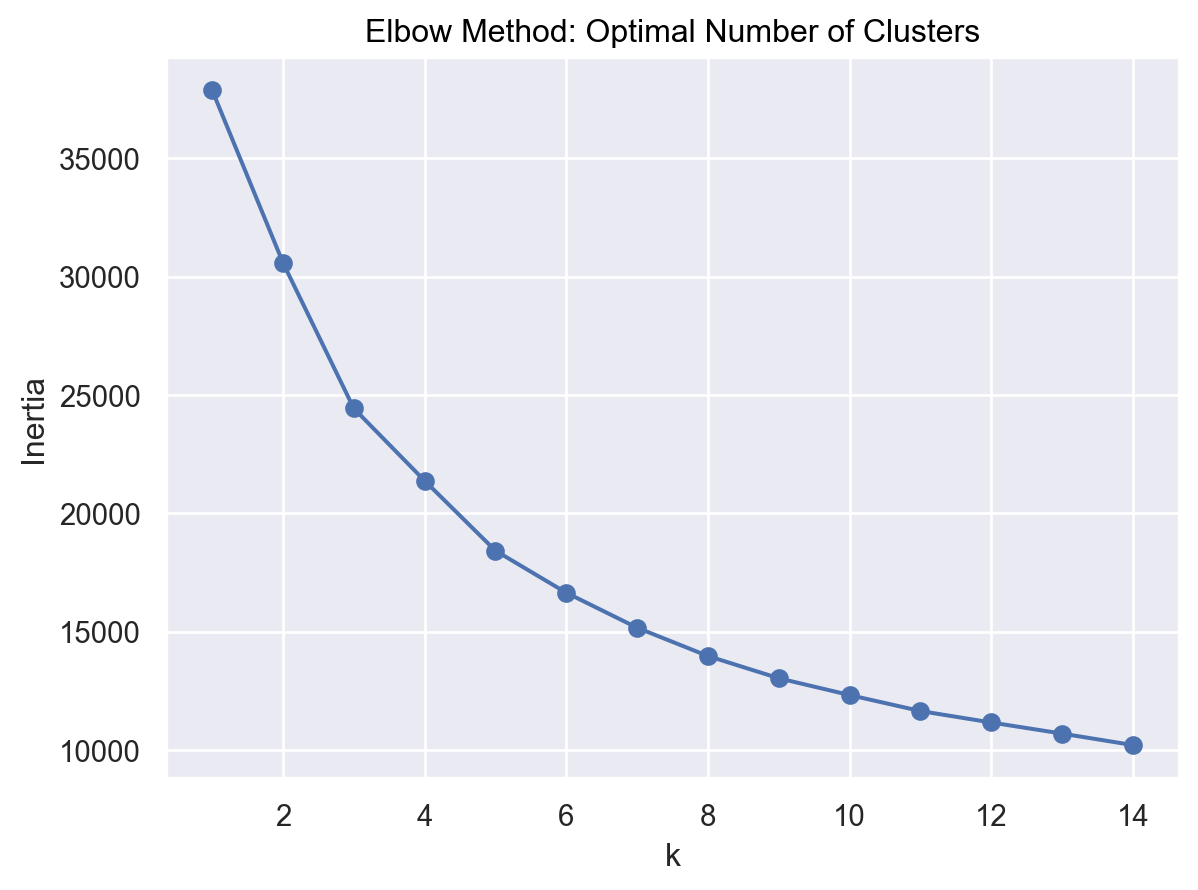

In [13]:
# Elbow Method
inertia = []
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=49)
    kmeans.fit(X_scaled)
    inertia.append([k, kmeans.inertia_])

# Plot Elbow Method
(
    pd.DataFrame(inertia, columns=['k', 'Inertia'])
    .pipe(so.Plot, x='k', y='Inertia')
    .add(so.Line(marker='o'))
    .label(title="Elbow Method: Optimal Number of Clusters", xlabel="Number of Clusters (k)", ylabel="Inertia")
)


In [ ]:
# Silhouette Analysis
silhouette = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=49)
    kmeans.fit(X_scaled)
    silhouette.append([k, silhouette_score(X_scaled, kmeans.labels_)])

# Plot Silhouette Scores
(
    pd.DataFrame(silhouette, columns=['k', 'Silhouette'])
    .pipe(so.Plot, x='k', y='Silhouette')
    .add(so.Line(marker='o'))
    .label(title="Silhouette Analysis: Optimal Number of Clusters", xlabel="Number of Clusters (k)", ylabel="Silhouette Score")
)


In [ ]:
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, n_init=20, random_state=49)
jobs['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualization: Scatter Plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
columns = ['Posting_Type', 'Agency', 'Career_Level', 'Full-Time_Part-Time_indicator']

for i, ax in enumerate(axes.flatten()):
    sns.scatterplot(
        x=jobs[columns[i]],
        y=jobs['Average_Salary'],
        hue=jobs['Cluster'].astype(str),
        palette="viridis",
        ax=ax
    )
    ax.set_title(f"Average Salary vs {columns[i]}")
    ax.set_xlabel(columns[i])
    ax.set_ylabel('Average Salary')

plt.tight_layout()
plt.show()


### Answer to Research Question 1:
**B. Clustering**

- The Elbow method suggests the optimal number of clusters as 6, while the Silhouette score indicates 12 as optimal, with a local maximum also at 6. Considering both methods, the number of clusters (k) is set to 6.
- The clustering analysis struggles to form well-defined clusters using the features  `Posting_Type`,`Agency`,`Career_Level`,`Full-Time_Part-Time_indicator` in relation to `Average_Salary`

## Research Question 2 : What are the main wage distinctions between competitive job postings and those that are not?

In [ ]:

# 1. Feature Engineering
jobs['Average_Salary'] = (jobs['Salary_Range_From'] + jobs['Salary_Range_To']) / 2
X = jobs[['Average_Salary', 'Job_Category']]
y = jobs['Competitive']

# 2.Encode categorical features
X = pd.get_dummies(X, columns=['Job_Category'], drop_first=True)

# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. Train Model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 5. Evaluate Model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# 6. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Competitive', 'Competitive'],
            yticklabels=['Non-Competitive', 'Competitive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 7. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# 8. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

# 9. Histogram of Predicted Probabilities
plt.figure(figsize=(8, 6))
sns.histplot(y_prob, bins=20, kde=True, color='purple')
plt.title("Histogram of Predicted Probabilities")
plt.xlabel("Predicted Probability for Competitive (Class 1)")
plt.ylabel("Frequency")
plt.show()

# 10. Comparative Analysis
competitive_salaries = jobs[jobs['Competitive'] == 1]['Average_Salary']
non_competitive_salaries = jobs[jobs['Competitive'] == 0]['Average_Salary']

# Descriptive Stats
print("\nDescriptive Statistics for Competitive Salaries:\n", competitive_salaries.describe())
print("\nDescriptive Statistics for Non-Competitive Salaries:\n", non_competitive_salaries.describe())

# Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Competitive', y='Average_Salary', data=jobs, palette="coolwarm")
plt.title("Salary Comparison Between Competitive and Non-Competitive Jobs")
plt.xlabel("Competitive (1=Yes, 0=No)")
plt.ylabel("Average Salary")
plt.show()


### Answer to Research Problem

**1. Classification Metrics and Confusion Matrix**
- Accuracy: 95%  
- Precision & Recall:
  - Competitive (Label 1): Precision (96%), Recall (96%), F1-Score (96%)
  - Non-Competitive (Label 0): Precision (93%), Recall (92%), F1-Score (92%)
- Confusion Matrix:
  - Correctly identified:  
    - 517 non-competitive postings  
    - 1023 competitive postings  
  - Misclassifications:  
    - 45 competitive as non-competitive  
    - 39 non-competitive as competitive  

**ROC Curve**
- AUC: 0.97, indicating strong discriminatory power.

**Precision-Recall Curve**
- High precision and recall across thresholds, confirming reliable predictions, particularly for competitive postings.

**Descriptive Salary Statistics**
 - Competitive Salaries:
   - Median: $77,108  

   - Mean: $78,281 (SD = $31,913)  
   - Range: $20.64 - $226,875  
 - Non-Competitive Salaries:
   - Median: $77,705  

   - Mean: $81,641 (SD = $45,264)  
   - Range: $15.45 - $317,000  

**Insights on Wage Distinctions**
- Median salaries are similar for both job types ($77,108 vs. $77,705).
- Non-competitive roles show more salary variability, potentially reflecting senior or niche positions.
- Competitive roles have more standardized salaries, likely influenced by market norms or organizational policies.


**Histogram of Predicted Probabilities**
     - Predominantly extreme values (near 0 or 1), indicating high model confidence.
     - Few predictions with moderate probabilities (0.4 to 0.6), suggesting minimal ambiguity.

**Boxplot: Salary Comparison**
     - Non-Competitive Jobs (Class 0): Wider salary distribution, lower median, and fewer extreme outliers.
     - Competitive Jobs (Class 1): Higher median, narrower salary range, with more high-salary outliers.
   - Comparison:  
     - Non-competitive jobs have higher salary variability but lower medians.  
     - Competitive jobs have less variability and higher medians.


**Summary:**

Competitive job postings usually have more consistent salaries with smaller differences, while non-competitive job postings have a wider range of salaries, showing more variation, possibly due to different types of roles or experience levels.



## Research Question 3 : Do residency requirements make some organizations more likely to have open positions?

In [ ]:
# Step 1: Preprocessing the text and labels
def classify_residency_requirement(text):
    '''Function to classify residency requirement'''
    text = text.lower()
    if 'residency is required' in text or 'city residency is required' in text:
        return 'Residency Required'
    elif 'residency is not required' in text or 'city residency is not required' in text or 'no residency requirement' in text:
        return 'No Residency Required'
    else:
        return 'Unclear'


# Apply the classification function to create a new column
jobs['Residency_Requirement_Category'] = jobs['Residency_Requirement'].apply(classify_residency_requirement)

# Step 2: Convert 'Agency' column to string
jobs['Agency'] = jobs['Agency'].astype(str)

# Step 3: Feature engineering using TF-IDF for the 'Residency_Requirement'
X = jobs['Residency_Requirement'] 
y = jobs['Residency_Requirement_Category'] 

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Create a ML pipeline with TF-IDF and Logistic Regression with L2 regularization
pipeline = make_pipeline(
    TfidfVectorizer(stop_words='english'), 
    LogisticRegression(solver='liblinear', penalty='l2')
)

# Hyperparameter tuning using GridSearchCV for Logistic Regression
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10], 
    'logisticregression__max_iter': [100, 200, 300]  
}

# Step 6: GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Step 7: Best parameters and evaluation
print("Best Parameters from GridSearchCV:", grid_search.best_params_)

# Step 8: Model evaluation on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Classification report for evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Step 9: K-fold Cross-validation for better model evaluation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(best_model, X, y, cv=kfold, scoring='accuracy')
print(f"K-fold Cross-validation Results: {cv_results}")
print(f"Mean CV Accuracy: {cv_results.mean()}")

agency_residency_group = jobs.groupby(['Agency', 'Residency_Requirement_Category'])['#_Of_Positions'].sum().reset_index()

# Step 12: Define custom colors for each residency category
category_colors = {
    'Residency Required': 'blue',
    'No Residency Required': 'green',
    'Unclear': 'orange'
}

sns.set_palette([category_colors['Residency Required'], category_colors['No Residency Required'], category_colors['Unclear']])

# Step 13: Visualization using bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=agency_residency_group, x='Agency', y='#_Of_Positions', hue='Residency_Requirement_Category', dodge=True)

# Rotate agency names
plt.xticks(rotation=90)

# Set the title and labels
plt.title('Job Postings by Agency and Residency Requirement')
plt.xlabel('Agency')
plt.ylabel('Number of Job Postings')

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=['No Residency Required', 'Residency Required', 'Unclear'], title='Residency Requirement')

plt.show()


### Answer to Research Question 3:

1. Best Parameters from GridSearchCV:
   - The optimal parameters identified by GridSearchCV for the Logistic Regression model areC = 10 and max_iter = 100.
2. Classification Report:
   - Overall Accuracy: 100% (perfect classification).
   - No Residency Required: Precision, recall, and F1-score are all 100%.
   - Residency Required: Precision is 100%, but recall is 92%, meaning the model missed a few instances (false negatives).
   - Unclear: Perfect performance with 100% precision, recall, and F1-score.
   - Averages:
     - Macro Average: Precision is 100%, recall is 97%, and F1-score is 98%.
     - Weighted Average: All metrics are 100%, indicating the model works well across all classes.

   - In summary, the model performs nearly perfectly, with a small drop in recall for "Residency Required".
3. Confusion Matrix
   - No Residency Required:476 correct predictions,0 false positives (incorrectly classified as "Residency Required" or "Unclear") and 1 false negative (incorrectly classified as "Unclear").
   - Residency Required:11 correct predictions,0 false positives for "No Residency Required" or "Unclear" and 1 false negative (incorrectly classified as "Unclear").
   - Unclear:593 correct predictions,1 false positive (incorrectly classified as "No Residency Required") and 1 false negative (incorrectly classified as "Residency Required").
   - Overall, the matrix shows excellent performance with very few misclassifications.
4. K-Fold Cross-Validation
   - Mean cross-validation accuracy is approximately 0.9957 (99.57%), which indicates that the model performs very well on unseen data and is highly consistent across the different folds. 

- The dataset shows significant variation across agencies, with some agencies having a high number of postings that either require residency, do not require residency, or have unclear requirements.

## Reseach Question 4 : Does the demography that is drawn to external postings differ from that of internal postings?

In [ ]:
results_summary = {}

jobs['Posting_Type'] = jobs['Posting_Type'].replace({0: 'External', 1: 'Internal'})

# Step 1: Data Overview
results_summary['Data Overview'] = jobs.info()

# Step 2: Posting Type Distribution
posting_counts = jobs['Posting_Type'].value_counts()
results_summary['Posting Type Distribution'] = posting_counts.to_frame()

plt.figure(figsize=(8, 5))
sns.countplot(data=jobs, x='Posting_Type', palette='viridis')
plt.title("Distribution of Posting Types (External vs Internal")
plt.xlabel("Posting Type")
plt.ylabel("Count")
plt.show()
print("\n\n")

# Step 3: Salary Distribution by Posting Type
jobs['Average_Salary'] = (jobs['Salary_Range_From'] + jobs['Salary_Range_To']) / 2
salary_summary = jobs.groupby('Posting_Type')['Average_Salary'].describe()
results_summary['Salary Summary'] = salary_summary

plt.figure(figsize=(10, 6))
sns.boxplot(data=jobs, x='Posting_Type', y='Average_Salary', palette='coolwarm')
plt.title("Salary Distribution by Posting Type(External vs Internal")
plt.xlabel("Posting Type")
plt.ylabel("Average Salary")
plt.show()
print("\n\n")

# Step 4: Career Levels by Posting Type
career_level_counts = jobs.groupby(['Posting_Type', 'Career_Level']).size().unstack(fill_value=0)
results_summary['Career Levels by Posting Type'] = career_level_counts

career_level_counts.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='plasma')
plt.title("Career Levels by Posting Type(External vs Internal")
plt.xlabel("Posting Type")
plt.ylabel("Count")
plt.legend(title="Career Levels", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
print("\n\n")
work_location_counts = jobs.groupby(['Posting_Type', 'Work_Location']).size().unstack(fill_value=0)
results_summary['Work Locations by Posting Type'] = work_location_counts.head()

top_locations = jobs['Work_Location'].value_counts().head(10).index
top_jobs = jobs[jobs['Work_Location'].isin(top_locations)]

plt.figure(figsize=(12, 6))
sns.countplot(data=top_jobs, x='Work_Location', hue='Posting_Type', palette='mako', order=top_locations)
plt.title("Top 10 Work Locations by Posting Type(External vs Internal")
plt.xlabel("Work Location")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(title="Posting Type")
plt.tight_layout()
plt.show()


In [ ]:
def display_summary(key, table):
    '''Function to Tabulate above results'''
    print(f"=== {key} ===")
    if isinstance(table, pd.DataFrame):
        print(tabulate(table, headers='keys', tablefmt='fancy_grid', showindex=True))
    else:
        print(table)
    print("\n")

# display
for key, table in results_summary.items():
    if key == "Work Locations by Posting Type":
        continue  # Skip displaying this table
    display_summary(key, table)


### Answer to Research Question 4

1. Bar Chart(Distribution of posting Type)
    - The number of External job posting and internal job postings are some what balanced and count of internal job posting is little bit higher than external job posting.
2. Box Plot(Salary Distribution by Posting Type)
   - The median salary is slightly higher for internal postings compared to external postings.That means,internal postings tend to offer slightly higher median salaries than external postings.
   - The IQR appears to be similar for both posting types, indicating comparable variability in the middle 50% of salaries.
   - Both distributions have outliers on the higher and lower ends. Hence both posting types occasionally result in exceptionally high/low salaries, but these cases are rare.
   -  The salary distribution across both types is generally consistent.
3. Stacked Bar Chart(Carrer Levels by Posting Type)
   - For both external and internal postings, the majority of job roles are categorized as `Experienced (non-manager)`.
   - areer levels such as `Manager`, `Student`, `Entry-Level` and `Executive` have smaller proportions of the total postings.
   - The proportions of career levels for external and internal postings are very similar, suggesting consistency in the distribution of job roles regardless of the posting type.
   - Most postings, whether internal or external, are targeted at experienced professionals, indicating a primary focus on this career level.
   - The representation of entry-level and student roles is quite small, which may reflect organizational hiring strategies or job market conditions.
4. Grouped Bar Chart(Work Locations by Posting Type)
   - `30-30 Thomson Ave L I City Qns` and `96-05 Horace Harding Expway` have the highest posting counts for both external and internal types, with nearly equal distribution between the two.
   - Locations like `55 Water St NY NY` and `59-17 Junction Blvd Corona Ny` have  higher counts for internal postings, whereas locations like `4 World Trade Center` show a slight preference for external postings.
   - For most locations, the counts for external and internal postings are very similar, indicating no strong preference for either type of posting at these locations.



## Conclusion

We successfully addressed all four research questions, and this project provides a comprehensive interpretation of NYC job postings through data analysis and visualization